In [1]:
# importing libaries

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

In [2]:
class coRNNCell(nn.Module):
    def __init__(self, n_inp, n_hid, dt, gamma, epsilon):
        super(coRNNCell, self).__init__()
        self.dt = dt
        self.gamma = gamma
        self.epsilon = epsilon
        self.i2h = nn.Linear(n_inp + n_hid + n_hid, n_hid)

    def forward(self, x, hy, hz):
        hz = hz + self.dt * (torch.tanh(self.i2h(torch.cat((x, hz, hy), 1)))
                             - self.gamma * hy - self.epsilon * hz)
        hy = hy + self.dt * hz

        return hy, hz

# Define the coRNN model
class coRNN(nn.Module):
    def __init__(self, n_inp, n_hid, n_out, dt, gamma, epsilon):
        super(coRNN, self).__init__()
        self.n_hid = n_hid
        self.cell = coRNNCell(n_inp, n_hid, dt, gamma, epsilon)
        self.readout = nn.Linear(n_hid, n_out)

    def forward(self, x):
        hy = torch.zeros(x.size(1), self.n_hid)
        hz = torch.zeros(x.size(1), self.n_hid)

        for t in range(x.size(0)):
            hy, hz = self.cell(x[t], hy, hz)
        output = self.readout(hy)

        return output

In [3]:
# Toy problem data
input_size = 256  # number of columns in a dataset
hidden_size = 32  # number of neurons
output_size = 256  
sequence_length = 160  # number of sequences/ number of rows
batch_size = 1
num_epochs = 30000

In [4]:
# importing data

In [5]:
# Load the .mat file
v_data = scipy.io.loadmat('v.mat')
h_data = scipy.io.loadmat('h.mat')
x_data = scipy.io.loadmat('x.mat')


In [6]:
x = x_data['X']
u = h_data['h']

In [7]:
# Set random seed for reproducibility
torch.manual_seed(42)

In [8]:
input_data = u[0:160,:]
target_data = u[1:161, :]

test_data = u[160, :]
#test_target = u[161:201, :]

print("test data shape", test_data.shape)
#print("test target shape", test_target.shape)

print("input data shape",input_data.shape)
print("Target data shape",target_data.shape)

test data shape (256,)
input data shape (160, 256)
Target data shape (160, 256)


In [9]:
# Convert data to tensors
input_tensor = torch.tensor(input_data).view(batch_size, sequence_length, input_size).float()
target_tensor = torch.tensor(target_data).view(batch_size, sequence_length, output_size).float()

print("input tensor shape",input_tensor.shape)
print("Target tensor shape",target_tensor.shape)

input tensor shape torch.Size([1, 160, 256])
Target tensor shape torch.Size([1, 160, 256])


In [10]:
# Convert test data to tensors
test_tensor = torch.tensor(test_data).view(batch_size, 1, input_size).float()
#test_target_tensor = torch.tensor(test_target).view(batch_size, 40, output_size).float()


In [11]:
# Create coRNN instance
cornn = coRNN(input_size, hidden_size, output_size, dt=0.1, gamma=1.0, epsilon=0.01)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(cornn.parameters(), lr=0.001)

# Training loop
for epoch in range(num_epochs):
    # Forward pass
    output = cornn(input_tensor)
    loss = criterion(output, target_tensor)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print progress
    if (epoch+1) % 10 == 0:
        print(f'Epoch: {epoch+1}/{num_epochs}, Loss: {loss.item():.8f}')


with torch.no_grad():
    prediction = cornn(test_tensor)

print(prediction.shape)

final_time_output = prediction[-1, :]
print(final_time_output.shape)

final_out = final_time_output.detach().numpy().reshape(-1,1)
final_true = u[:,-1].reshape(-1,1)





Epoch: 10/30000, Loss: 0.72874385
Epoch: 20/30000, Loss: 0.71368051
Epoch: 30/30000, Loss: 0.69919413
Epoch: 40/30000, Loss: 0.68518984
Epoch: 50/30000, Loss: 0.67164361
Epoch: 60/30000, Loss: 0.65853310


/data/localhome/tkapoor/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1, 160, 256])) that is different to the input size (torch.Size([160, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 70/30000, Loss: 0.64583015
Epoch: 80/30000, Loss: 0.63350725
Epoch: 90/30000, Loss: 0.62154043
Epoch: 100/30000, Loss: 0.60990894
Epoch: 110/30000, Loss: 0.59859467
Epoch: 120/30000, Loss: 0.58758146
Epoch: 130/30000, Loss: 0.57685506
Epoch: 140/30000, Loss: 0.56640261
Epoch: 150/30000, Loss: 0.55621243
Epoch: 160/30000, Loss: 0.54627371
Epoch: 170/30000, Loss: 0.53657657
Epoch: 180/30000, Loss: 0.52711189
Epoch: 190/30000, Loss: 0.51787120
Epoch: 200/30000, Loss: 0.50884640
Epoch: 210/30000, Loss: 0.50003022
Epoch: 220/30000, Loss: 0.49141568
Epoch: 230/30000, Loss: 0.48299623
Epoch: 240/30000, Loss: 0.47476560
Epoch: 250/30000, Loss: 0.46671790
Epoch: 260/30000, Loss: 0.45884761
Epoch: 270/30000, Loss: 0.45114937
Epoch: 280/30000, Loss: 0.44361821
Epoch: 290/30000, Loss: 0.43624920
Epoch: 300/30000, Loss: 0.42903775
Epoch: 310/30000, Loss: 0.42197943
Epoch: 320/30000, Loss: 0.41507000
Epoch: 330/30000, Loss: 0.40830532
Epoch: 340/30000, Loss: 0.40168151
Epoch: 350/30000, Loss:

Epoch: 2390/30000, Loss: 0.03837682
Epoch: 2400/30000, Loss: 0.03818259
Epoch: 2410/30000, Loss: 0.03799236
Epoch: 2420/30000, Loss: 0.03780606
Epoch: 2430/30000, Loss: 0.03762362
Epoch: 2440/30000, Loss: 0.03744498
Epoch: 2450/30000, Loss: 0.03727007
Epoch: 2460/30000, Loss: 0.03709883
Epoch: 2470/30000, Loss: 0.03693120
Epoch: 2480/30000, Loss: 0.03676711
Epoch: 2490/30000, Loss: 0.03660651
Epoch: 2500/30000, Loss: 0.03644933
Epoch: 2510/30000, Loss: 0.03629552
Epoch: 2520/30000, Loss: 0.03614501
Epoch: 2530/30000, Loss: 0.03599775
Epoch: 2540/30000, Loss: 0.03585368
Epoch: 2550/30000, Loss: 0.03571275
Epoch: 2560/30000, Loss: 0.03557489
Epoch: 2570/30000, Loss: 0.03544006
Epoch: 2580/30000, Loss: 0.03530820
Epoch: 2590/30000, Loss: 0.03517926
Epoch: 2600/30000, Loss: 0.03505317
Epoch: 2610/30000, Loss: 0.03492991
Epoch: 2620/30000, Loss: 0.03480940
Epoch: 2630/30000, Loss: 0.03469161
Epoch: 2640/30000, Loss: 0.03457647
Epoch: 2650/30000, Loss: 0.03446395
Epoch: 2660/30000, Loss: 0.0

Epoch: 4670/30000, Loss: 0.03034838
Epoch: 4680/30000, Loss: 0.03034833
Epoch: 4690/30000, Loss: 0.03034830
Epoch: 4700/30000, Loss: 0.03034826
Epoch: 4710/30000, Loss: 0.03034823
Epoch: 4720/30000, Loss: 0.03034820
Epoch: 4730/30000, Loss: 0.03034817
Epoch: 4740/30000, Loss: 0.03034814
Epoch: 4750/30000, Loss: 0.03034811
Epoch: 4760/30000, Loss: 0.03034809
Epoch: 4770/30000, Loss: 0.03034807
Epoch: 4780/30000, Loss: 0.03034804
Epoch: 4790/30000, Loss: 0.03034803
Epoch: 4800/30000, Loss: 0.03034801
Epoch: 4810/30000, Loss: 0.03034799
Epoch: 4820/30000, Loss: 0.03034797
Epoch: 4830/30000, Loss: 0.03034796
Epoch: 4840/30000, Loss: 0.03034795
Epoch: 4850/30000, Loss: 0.03034793
Epoch: 4860/30000, Loss: 0.03034792
Epoch: 4870/30000, Loss: 0.03034791
Epoch: 4880/30000, Loss: 0.03034790
Epoch: 4890/30000, Loss: 0.03034789
Epoch: 4900/30000, Loss: 0.03034788
Epoch: 4910/30000, Loss: 0.03034787
Epoch: 4920/30000, Loss: 0.03034786
Epoch: 4930/30000, Loss: 0.03034786
Epoch: 4940/30000, Loss: 0.0

Epoch: 6960/30000, Loss: 0.02371900
Epoch: 6970/30000, Loss: 0.02367442
Epoch: 6980/30000, Loss: 0.02363016
Epoch: 6990/30000, Loss: 0.02358621
Epoch: 7000/30000, Loss: 0.02354258
Epoch: 7010/30000, Loss: 0.02349924
Epoch: 7020/30000, Loss: 0.02345620
Epoch: 7030/30000, Loss: 0.02341344
Epoch: 7040/30000, Loss: 0.02337095
Epoch: 7050/30000, Loss: 0.02332874
Epoch: 7060/30000, Loss: 0.02328679
Epoch: 7070/30000, Loss: 0.02324509
Epoch: 7080/30000, Loss: 0.02320365
Epoch: 7090/30000, Loss: 0.02316245
Epoch: 7100/30000, Loss: 0.02312149
Epoch: 7110/30000, Loss: 0.02308076
Epoch: 7120/30000, Loss: 0.02304026
Epoch: 7130/30000, Loss: 0.02299999
Epoch: 7140/30000, Loss: 0.02295993
Epoch: 7150/30000, Loss: 0.02292010
Epoch: 7160/30000, Loss: 0.02288046
Epoch: 7170/30000, Loss: 0.02284104
Epoch: 7180/30000, Loss: 0.02280181
Epoch: 7190/30000, Loss: 0.02276279
Epoch: 7200/30000, Loss: 0.02272395
Epoch: 7210/30000, Loss: 0.02268531
Epoch: 7220/30000, Loss: 0.02264685
Epoch: 7230/30000, Loss: 0.0

Epoch: 9260/30000, Loss: 0.01671876
Epoch: 9270/30000, Loss: 0.01669509
Epoch: 9280/30000, Loss: 0.01667146
Epoch: 9290/30000, Loss: 0.01664786
Epoch: 9300/30000, Loss: 0.01662429
Epoch: 9310/30000, Loss: 0.01660076
Epoch: 9320/30000, Loss: 0.01657727
Epoch: 9330/30000, Loss: 0.01655381
Epoch: 9340/30000, Loss: 0.01653038
Epoch: 9350/30000, Loss: 0.01650699
Epoch: 9360/30000, Loss: 0.01648363
Epoch: 9370/30000, Loss: 0.01646031
Epoch: 9380/30000, Loss: 0.01643702
Epoch: 9390/30000, Loss: 0.01641376
Epoch: 9400/30000, Loss: 0.01639054
Epoch: 9410/30000, Loss: 0.01636735
Epoch: 9420/30000, Loss: 0.01634420
Epoch: 9430/30000, Loss: 0.01632107
Epoch: 9440/30000, Loss: 0.01629798
Epoch: 9450/30000, Loss: 0.01627493
Epoch: 9460/30000, Loss: 0.01625191
Epoch: 9470/30000, Loss: 0.01622891
Epoch: 9480/30000, Loss: 0.01620596
Epoch: 9490/30000, Loss: 0.01618303
Epoch: 9500/30000, Loss: 0.01616014
Epoch: 9510/30000, Loss: 0.01613728
Epoch: 9520/30000, Loss: 0.01611445
Epoch: 9530/30000, Loss: 0.0

Epoch: 11530/30000, Loss: 0.01208584
Epoch: 11540/30000, Loss: 0.01206824
Epoch: 11550/30000, Loss: 0.01205067
Epoch: 11560/30000, Loss: 0.01203310
Epoch: 11570/30000, Loss: 0.01201558
Epoch: 11580/30000, Loss: 0.01199806
Epoch: 11590/30000, Loss: 0.01198056
Epoch: 11600/30000, Loss: 0.01196309
Epoch: 11610/30000, Loss: 0.01194564
Epoch: 11620/30000, Loss: 0.01192822
Epoch: 11630/30000, Loss: 0.01191081
Epoch: 11640/30000, Loss: 0.01189343
Epoch: 11650/30000, Loss: 0.01187606
Epoch: 11660/30000, Loss: 0.01185872
Epoch: 11670/30000, Loss: 0.01184140
Epoch: 11680/30000, Loss: 0.01182411
Epoch: 11690/30000, Loss: 0.01180683
Epoch: 11700/30000, Loss: 0.01178957
Epoch: 11710/30000, Loss: 0.01177234
Epoch: 11720/30000, Loss: 0.01175513
Epoch: 11730/30000, Loss: 0.01173799
Epoch: 11740/30000, Loss: 0.01172081
Epoch: 11750/30000, Loss: 0.01170363
Epoch: 11760/30000, Loss: 0.01168649
Epoch: 11770/30000, Loss: 0.01166938
Epoch: 11780/30000, Loss: 0.01165229
Epoch: 11790/30000, Loss: 0.01163523
E

Epoch: 13750/30000, Loss: 0.00866991
Epoch: 13760/30000, Loss: 0.00865659
Epoch: 13770/30000, Loss: 0.00864328
Epoch: 13780/30000, Loss: 0.00863025
Epoch: 13790/30000, Loss: 0.00861674
Epoch: 13800/30000, Loss: 0.00860348
Epoch: 13810/30000, Loss: 0.00859023
Epoch: 13820/30000, Loss: 0.00857701
Epoch: 13830/30000, Loss: 0.00856380
Epoch: 13840/30000, Loss: 0.00855061
Epoch: 13850/30000, Loss: 0.00853744
Epoch: 13860/30000, Loss: 0.00852428
Epoch: 13870/30000, Loss: 0.00851115
Epoch: 13880/30000, Loss: 0.00849803
Epoch: 13890/30000, Loss: 0.00848493
Epoch: 13900/30000, Loss: 0.00847184
Epoch: 13910/30000, Loss: 0.00845877
Epoch: 13920/30000, Loss: 0.00844572
Epoch: 13930/30000, Loss: 0.00843268
Epoch: 13940/30000, Loss: 0.00841966
Epoch: 13950/30000, Loss: 0.00840666
Epoch: 13960/30000, Loss: 0.00839367
Epoch: 13970/30000, Loss: 0.00838070
Epoch: 13980/30000, Loss: 0.00836775
Epoch: 13990/30000, Loss: 0.00835481
Epoch: 14000/30000, Loss: 0.00834190
Epoch: 14010/30000, Loss: 0.00832914
E

Epoch: 15990/30000, Loss: 0.00608122
Epoch: 16000/30000, Loss: 0.00607137
Epoch: 16010/30000, Loss: 0.00606144
Epoch: 16020/30000, Loss: 0.00605156
Epoch: 16030/30000, Loss: 0.00604170
Epoch: 16040/30000, Loss: 0.00603184
Epoch: 16050/30000, Loss: 0.00602200
Epoch: 16060/30000, Loss: 0.00601217
Epoch: 16070/30000, Loss: 0.00600236
Epoch: 16080/30000, Loss: 0.00599256
Epoch: 16090/30000, Loss: 0.00598278
Epoch: 16100/30000, Loss: 0.00597301
Epoch: 16110/30000, Loss: 0.00596325
Epoch: 16120/30000, Loss: 0.00595351
Epoch: 16130/30000, Loss: 0.00594378
Epoch: 16140/30000, Loss: 0.00593406
Epoch: 16150/30000, Loss: 0.00592436
Epoch: 16160/30000, Loss: 0.00591467
Epoch: 16170/30000, Loss: 0.00590499
Epoch: 16180/30000, Loss: 0.00589533
Epoch: 16190/30000, Loss: 0.00588568
Epoch: 16200/30000, Loss: 0.00587608
Epoch: 16210/30000, Loss: 0.00586642
Epoch: 16220/30000, Loss: 0.00585685
Epoch: 16230/30000, Loss: 0.00584724
Epoch: 16240/30000, Loss: 0.00583764
Epoch: 16250/30000, Loss: 0.00582806
E

Epoch: 18250/30000, Loss: 0.00416222
Epoch: 18260/30000, Loss: 0.00415505
Epoch: 18270/30000, Loss: 0.00414789
Epoch: 18280/30000, Loss: 0.00414074
Epoch: 18290/30000, Loss: 0.00413360
Epoch: 18300/30000, Loss: 0.00412647
Epoch: 18310/30000, Loss: 0.00411935
Epoch: 18320/30000, Loss: 0.00411225
Epoch: 18330/30000, Loss: 0.00410515
Epoch: 18340/30000, Loss: 0.00409806
Epoch: 18350/30000, Loss: 0.00409098
Epoch: 18360/30000, Loss: 0.00408392
Epoch: 18370/30000, Loss: 0.00407686
Epoch: 18380/30000, Loss: 0.00406982
Epoch: 18390/30000, Loss: 0.00406308
Epoch: 18400/30000, Loss: 0.00405600
Epoch: 18410/30000, Loss: 0.00404883
Epoch: 18420/30000, Loss: 0.00404177
Epoch: 18430/30000, Loss: 0.00403476
Epoch: 18440/30000, Loss: 0.00402777
Epoch: 18450/30000, Loss: 0.00402080
Epoch: 18460/30000, Loss: 0.00401384
Epoch: 18470/30000, Loss: 0.00400689
Epoch: 18480/30000, Loss: 0.00399995
Epoch: 18490/30000, Loss: 0.00399303
Epoch: 18500/30000, Loss: 0.00398611
Epoch: 18510/30000, Loss: 0.00397920
E

Epoch: 20500/30000, Loss: 0.00279701
Epoch: 20510/30000, Loss: 0.00279196
Epoch: 20520/30000, Loss: 0.00278692
Epoch: 20530/30000, Loss: 0.00278188
Epoch: 20540/30000, Loss: 0.00277686
Epoch: 20550/30000, Loss: 0.00277184
Epoch: 20560/30000, Loss: 0.00276683
Epoch: 20570/30000, Loss: 0.00276183
Epoch: 20580/30000, Loss: 0.00275684
Epoch: 20590/30000, Loss: 0.00275186
Epoch: 20600/30000, Loss: 0.00274688
Epoch: 20610/30000, Loss: 0.00274191
Epoch: 20620/30000, Loss: 0.00273695
Epoch: 20630/30000, Loss: 0.00273200
Epoch: 20640/30000, Loss: 0.00272706
Epoch: 20650/30000, Loss: 0.00272212
Epoch: 20660/30000, Loss: 0.00271720
Epoch: 20670/30000, Loss: 0.00271230
Epoch: 20680/30000, Loss: 0.00270795
Epoch: 20690/30000, Loss: 0.00270252
Epoch: 20700/30000, Loss: 0.00269757
Epoch: 20710/30000, Loss: 0.00269269
Epoch: 20720/30000, Loss: 0.00268781
Epoch: 20730/30000, Loss: 0.00268293
Epoch: 20740/30000, Loss: 0.00267807
Epoch: 20750/30000, Loss: 0.00267321
Epoch: 20760/30000, Loss: 0.00266837
E

Epoch: 22720/30000, Loss: 0.00185981
Epoch: 22730/30000, Loss: 0.00185612
Epoch: 22740/30000, Loss: 0.00185248
Epoch: 22750/30000, Loss: 0.00184897
Epoch: 22760/30000, Loss: 0.00184551
Epoch: 22770/30000, Loss: 0.00184206
Epoch: 22780/30000, Loss: 0.00183863
Epoch: 22790/30000, Loss: 0.00183519
Epoch: 22800/30000, Loss: 0.00183177
Epoch: 22810/30000, Loss: 0.00182835
Epoch: 22820/30000, Loss: 0.00182493
Epoch: 22830/30000, Loss: 0.00182152
Epoch: 22840/30000, Loss: 0.00181812
Epoch: 22850/30000, Loss: 0.00181472
Epoch: 22860/30000, Loss: 0.00181133
Epoch: 22870/30000, Loss: 0.00180795
Epoch: 22880/30000, Loss: 0.00180457
Epoch: 22890/30000, Loss: 0.00180120
Epoch: 22900/30000, Loss: 0.00179783
Epoch: 22910/30000, Loss: 0.00179447
Epoch: 22920/30000, Loss: 0.00179111
Epoch: 22930/30000, Loss: 0.00178776
Epoch: 22940/30000, Loss: 0.00178445
Epoch: 22950/30000, Loss: 0.00178183
Epoch: 22960/30000, Loss: 0.00177796
Epoch: 22970/30000, Loss: 0.00177447
Epoch: 22980/30000, Loss: 0.00177111
E

Epoch: 24940/30000, Loss: 0.00122302
Epoch: 24950/30000, Loss: 0.00122069
Epoch: 24960/30000, Loss: 0.00121837
Epoch: 24970/30000, Loss: 0.00121605
Epoch: 24980/30000, Loss: 0.00121373
Epoch: 24990/30000, Loss: 0.00121143
Epoch: 25000/30000, Loss: 0.00120915
Epoch: 25010/30000, Loss: 0.00120792
Epoch: 25020/30000, Loss: 0.00120470
Epoch: 25030/30000, Loss: 0.00120225
Epoch: 25040/30000, Loss: 0.00119995
Epoch: 25050/30000, Loss: 0.00119766
Epoch: 25060/30000, Loss: 0.00119539
Epoch: 25070/30000, Loss: 0.00119311
Epoch: 25080/30000, Loss: 0.00119084
Epoch: 25090/30000, Loss: 0.00118857
Epoch: 25100/30000, Loss: 0.00118631
Epoch: 25110/30000, Loss: 0.00118405
Epoch: 25120/30000, Loss: 0.00118180
Epoch: 25130/30000, Loss: 0.00117955
Epoch: 25140/30000, Loss: 0.00117730
Epoch: 25150/30000, Loss: 0.00117506
Epoch: 25160/30000, Loss: 0.00117282
Epoch: 25170/30000, Loss: 0.00117058
Epoch: 25180/30000, Loss: 0.00116835
Epoch: 25190/30000, Loss: 0.00116613
Epoch: 25200/30000, Loss: 0.00116391
E

Epoch: 27220/30000, Loss: 0.00078939
Epoch: 27230/30000, Loss: 0.00078775
Epoch: 27240/30000, Loss: 0.00078622
Epoch: 27250/30000, Loss: 0.00078469
Epoch: 27260/30000, Loss: 0.00078317
Epoch: 27270/30000, Loss: 0.00078164
Epoch: 27280/30000, Loss: 0.00078012
Epoch: 27290/30000, Loss: 0.00077860
Epoch: 27300/30000, Loss: 0.00077709
Epoch: 27310/30000, Loss: 0.00077558
Epoch: 27320/30000, Loss: 0.00077407
Epoch: 27330/30000, Loss: 0.00077256
Epoch: 27340/30000, Loss: 0.00077106
Epoch: 27350/30000, Loss: 0.00076956
Epoch: 27360/30000, Loss: 0.00076806
Epoch: 27370/30000, Loss: 0.00076657
Epoch: 27380/30000, Loss: 0.00076507
Epoch: 27390/30000, Loss: 0.00076358
Epoch: 27400/30000, Loss: 0.00076210
Epoch: 27410/30000, Loss: 0.00076061
Epoch: 27420/30000, Loss: 0.00075913
Epoch: 27430/30000, Loss: 0.00075765
Epoch: 27440/30000, Loss: 0.00075617
Epoch: 27450/30000, Loss: 0.00075470
Epoch: 27460/30000, Loss: 0.00075426
Epoch: 27470/30000, Loss: 0.00075233
Epoch: 27480/30000, Loss: 0.00075053
E

Epoch: 29480/30000, Loss: 0.00050337
Epoch: 29490/30000, Loss: 0.00050232
Epoch: 29500/30000, Loss: 0.00050127
Epoch: 29510/30000, Loss: 0.00050024
Epoch: 29520/30000, Loss: 0.00049921
Epoch: 29530/30000, Loss: 0.00049819
Epoch: 29540/30000, Loss: 0.00049717
Epoch: 29550/30000, Loss: 0.00049615
Epoch: 29560/30000, Loss: 0.00049514
Epoch: 29570/30000, Loss: 0.00049412
Epoch: 29580/30000, Loss: 0.00049311
Epoch: 29590/30000, Loss: 0.00049210
Epoch: 29600/30000, Loss: 0.00049109
Epoch: 29610/30000, Loss: 0.00049008
Epoch: 29620/30000, Loss: 0.00048907
Epoch: 29630/30000, Loss: 0.00048807
Epoch: 29640/30000, Loss: 0.00048707
Epoch: 29650/30000, Loss: 0.00048606
Epoch: 29660/30000, Loss: 0.00048507
Epoch: 29670/30000, Loss: 0.00048410
Epoch: 29680/30000, Loss: 0.00048515
Epoch: 29690/30000, Loss: 0.00048211
Epoch: 29700/30000, Loss: 0.00048110
Epoch: 29710/30000, Loss: 0.00048011
Epoch: 29720/30000, Loss: 0.00047913
Epoch: 29730/30000, Loss: 0.00047814
Epoch: 29740/30000, Loss: 0.00047715
E

(1, 256)
(1, 201)
(256, 201)


/data/localhome/tkapoor/.local/lib/python3.8/site-packages/numpy/ma/core.py:2820: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.8/dist-packages/matplotlib/contour.py:1180: ComplexWarning: Casting complex values to real discards the imaginary part
  self.levels = np.asarray(levels_arg).astype(np.float64)


<Figure size 432x288 with 0 Axes>

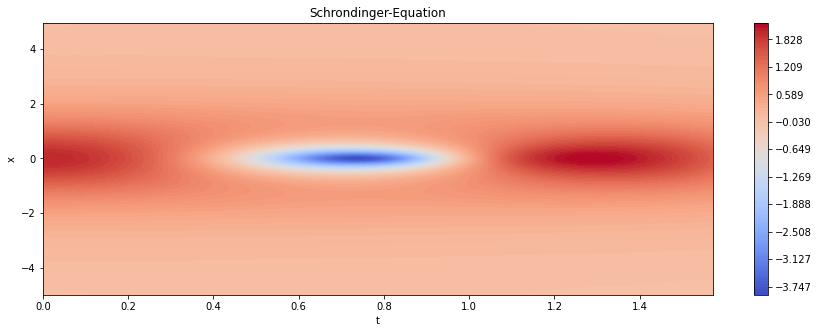

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from sklearn.model_selection import train_test_split

# Load the .mat file
mat_data = scipy.io.loadmat('NLS.mat')

# Following is the code to plot the data u vs x and t. u is 256*100
# matrix. Use first 75 columns for training and 25 for testing :)

# Access the variables stored in the .mat file
# The variable names in the .mat file become keys in the loaded dictionary
x = mat_data['x']
t = mat_data['tt']
u = mat_data['uu']

# Use the loaded variables as needed
print(x.shape)
print(t.shape)
print(u.shape)

X, T = np.meshgrid(x, t)
# Define custom color levels
c_levels = np.linspace(np.min(u), np.max(u), 100)

# Plot the contour
plt.figure()
plt.figure(figsize=(15, 5))
plt.contourf(T, X, u.T, levels=c_levels, cmap='coolwarm')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Schrondinger-Equation')
plt.colorbar()  # Add a colorbar for the contour levels
plt.show()

In [13]:
print(test_tensor.shape)
prediction_tensor = torch.zeros(1, 40, 256).float()
print(prediction_tensor.shape)

torch.Size([1, 1, 256])
torch.Size([1, 40, 256])


In [14]:
with torch.no_grad():
    prediction = cornn(test_tensor)
    prediction = prediction.view(1, 1, 256).float()
    prediction_tensor[:, 0, :] = prediction
    for i in range(39):
        prediction = cornn(prediction)
        prediction = prediction.view(1, 1, 256).float()
        prediction_tensor[:, i+1, :] = prediction

prediction (256,)


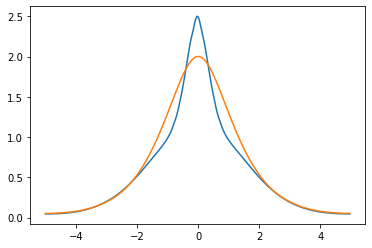

Relative Error Test:  1.0156650999704195 %


In [15]:



final_out = final_time_output.detach().numpy().reshape(-1,)
final_true = u[:,-1].reshape(-1,1)

final_true = np.abs(final_true)
final_out = np.abs(final_out)

print("prediction", final_out.shape)
plt.plot(x.T, final_out)
plt.plot(x.T, final_true)
plt.show()
# # quit()

# # # Flatten prediction tensor
# prediction = prediction.view(-1).numpy()
# print(prediction.shape)

# # # Convert NumPy arrays to PyTorch tensors
final_out_tensor = torch.from_numpy(final_out)
final_true_tensor = torch.from_numpy(final_true)

# print(final_out_tensor.shape)
# print(final_true_tensor.shape)

# # # Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((final_out_tensor - final_true_tensor)**2)/ torch.mean(final_true_tensor**2)

print("Relative Error Test: ", relative_error_test.item(), "%")

In [16]:
### snapshots

In [17]:
prediction_tensor = torch.squeeze(prediction_tensor)
h = np.abs(u)
h.shape

(256, 201)

(256, 1)
(256, 1)


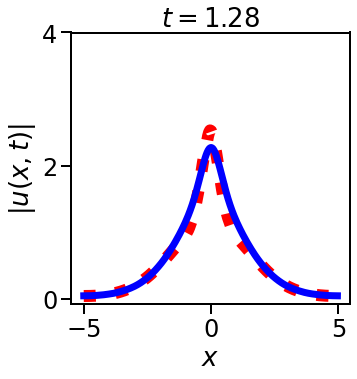

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Create the figure and axis objects with reduced width
fig, ax = plt.subplots(figsize=(5, 5))  # You can adjust the width (7 inches) and height (5 inches) as needed

# # Make sure the font is Times Roman
# plt.rcParams['font.family'] = 'Times New Roman'

# # Perform the prediction
# with torch.no_grad():
#     prediction = lem(test_tensor)

final_time_output = prediction_tensor[-38, :]
final_out = final_time_output.detach().numpy().reshape(-1, 1)
final_true = h[:, -38].reshape(-1, 1)
print(final_out.shape)
print(final_true.shape)

# Plot the data with red and blue lines, one with dotted and one with solid style
ax.plot(x.T, final_out, color='red', linestyle='dotted', linewidth=12, label='Prediction')
ax.plot(x.T, final_true, color='blue', linestyle='solid', linewidth=7, label='True')

# Set the axis labels with bold font weight
ax.set_xlabel(r"${x}$", fontsize=26, color='black', fontdict={'weight': 'bold'})
ax.set_ylabel(r"${|u(x, t)|}$", fontsize=26, color='black', fontdict={'weight': 'bold'})

# Set the title with bold font weight
ax.set_title(r"${t = 1.28}$", fontsize=26, color='black', fontweight='bold')

# Set the number of ticks for x-axis and y-axis to 3
ax.set_xticks([-5, 0, 5])
ax.set_yticks([0, 2, 4])

# Set tick labels fontweight to bold and increase font size
ax.tick_params(axis='both', which='major', labelsize=20, width=2, length=10)

# # Set the fontweight for tick labels to bold
# for tick in ax.get_xticklabels() + ax.get_yticklabels():
#     tick.set_weight('bold')

# Set the spines linewidth to bold
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)


# Increase font size for x and y axis numbers
ax.tick_params(axis='both', which='major', labelsize=24)

# Set the legend
# ax.legend()

plt.savefig('coRNN_1.28_20.pdf', dpi=500, bbox_inches="tight")

# Show the plot
plt.show()


(256, 1)
(256, 1)


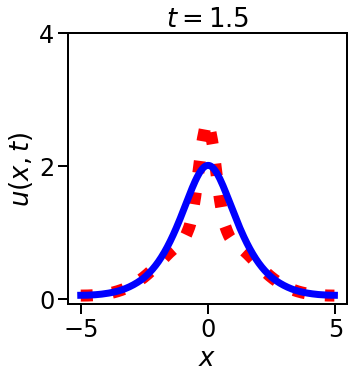

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Create the figure and axis objects with reduced width
fig, ax = plt.subplots(figsize=(5, 5))  # You can adjust the width (7 inches) and height (5 inches) as needed

# # Make sure the font is Times Roman
# plt.rcParams['font.family'] = 'Times New Roman'

# # Perform the prediction
# with torch.no_grad():
#     prediction = lem(test_tensor)


final_time_output = prediction_tensor[-3, :]
final_out = final_time_output.detach().numpy().reshape(-1, 1)
final_true = h[:, -3].reshape(-1, 1)
print(final_out.shape)
print(final_true.shape)

# Plot the data with red and blue lines, one with dotted and one with solid style
ax.plot(x.T, final_out, color='red', linestyle='dotted', linewidth=12, label='Prediction')
ax.plot(x.T, final_true, color='blue', linestyle='solid', linewidth=7, label='True')

# Set the axis labels with bold font weight
ax.set_xlabel(r"${x}$", fontsize=26, color='black', fontdict={'weight': 'bold'})
ax.set_ylabel(r"${u(x, t)}$", fontsize=26, color='black', fontdict={'weight': 'bold'})

# Set the title with bold font weight
ax.set_title(r"${t = 1.5}$", fontsize=26, color='black', fontweight='bold')

# Set the number of ticks for x-axis and y-axis to 3
ax.set_xticks([-5, 0, 5])
ax.set_yticks([0, 2, 4])

# Set tick labels fontweight to bold and increase font size
ax.tick_params(axis='both', which='major', labelsize=20, width=2, length=10)

# # Set the fontweight for tick labels to bold
# for tick in ax.get_xticklabels() + ax.get_yticklabels():
#     tick.set_weight('bold')

# Set the spines linewidth to bold
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)


# Increase font size for x and y axis numbers
ax.tick_params(axis='both', which='major', labelsize=24)

# Set the legend
# ax.legend()

plt.savefig('coRNN_1.5_20.pdf', dpi=500, bbox_inches="tight")

# Show the plot
plt.show()


### error

In [20]:
test_tensor.shape

torch.Size([1, 1, 256])

In [21]:
# true solution
h_true = np.abs(u)
h_true = h_true.T
print(h_true)


[[0.02695056 0.02802405 0.02914028 ... 0.03030097 0.02914028 0.02802405]
 [0.02830826 0.02846008 0.02892091 ... 0.02978105 0.02892091 0.02846008]
 [0.02890662 0.02901981 0.02934887 ... 0.02994636 0.02934887 0.02901981]
 ...
 [0.05102925 0.05110305 0.05126979 ... 0.05150113 0.05126979 0.05110305]
 [0.05115212 0.05109786 0.05112245 ... 0.05130366 0.05112245 0.05109786]
 [0.05105769 0.05101199 0.05109009 ... 0.05132839 0.05109009 0.05101199]]


In [22]:
# exact
u_test_full = h_true[161:201, :]
print(u_test_full.shape)

(40, 256)


In [23]:
k1 = (prediction_tensor - u_test_full)**2
u_test_full_tensor = torch.tensor(u_test_full**2)
prediction_tensor.shape

torch.Size([40, 256])

In [24]:
# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean(k1)/ torch.mean(u_test_full_tensor)

print("Relative Error Test: ", relative_error_test.item(), "%")

Relative Error Test:  0.04264380179514161 %


In [25]:
R_abs = torch.max(prediction_tensor-u_test_full)
print(R_abs)

tensor(0.6596, dtype=torch.float64)


In [26]:
import torch

a = prediction_tensor
b = u_test_full
# Assuming 'a' is your predicted values (model's predictions) and 'b' is the true values (ground truth)
# Make sure 'a' and 'b' are PyTorch tensors
b = torch.tensor(b)
# Calculate the mean of 'b'
mean_b = torch.mean(b)

# Calculate the Explained Variance Score
numerator = torch.var(b - a)  # Variance of the differences between 'b' and 'a'
denominator = torch.var(b)    # Variance of 'b'
evs = 1 - numerator / denominator

print("Explained Variance Score:", evs.item())


Explained Variance Score: 0.9250977371789145


In [27]:
R_mean = torch.mean(torch.abs(prediction_tensor - u_test_full))
print(R_mean)

tensor(0.1003, dtype=torch.float64)


### contour 80-20/

In [28]:
conc_u = torch.squeeze(input_tensor)
concatenated_tensor = torch.cat((conc_u, prediction_tensor), dim=0)

t1 = np.linspace(0, 1.5707 , 200)

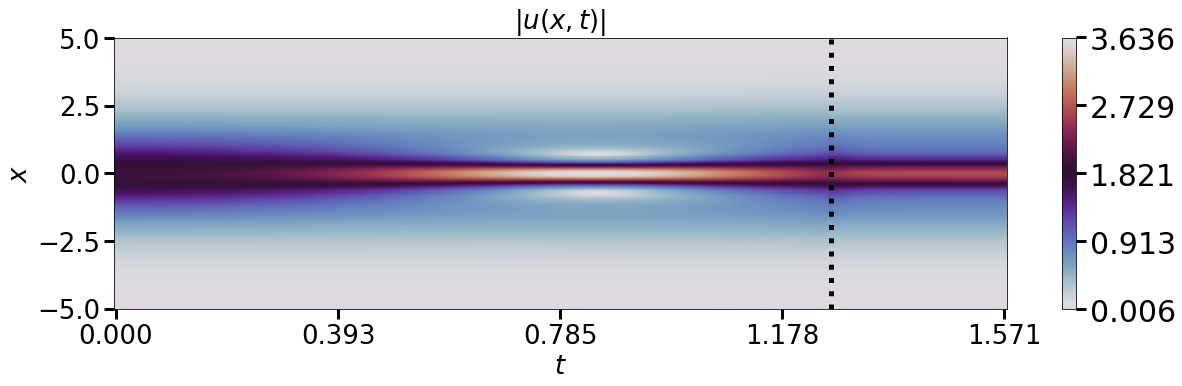

In [29]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator

# Assuming you have defined concatenated_tensor as a PyTorch tensor
# concatenated_tensor = torch.cat((tensor1, tensor2), dim=0)

# Convert concatenated_tensor to a NumPy array
concatenated_array = concatenated_tensor.numpy()

# Define custom color levels
x = np.linspace(-5, 5, concatenated_array.shape[1])  # Replace 0 and 1 with your actual x range
t = np.linspace(0, 1.57, concatenated_array.shape[0])  # Replace 0 and 1 with your actual t range
X, T = np.meshgrid(x, t1)

# Define custom color levels using the minimum and maximum from the NumPy array
c_levels = np.linspace(np.min(concatenated_array), np.max(concatenated_array), 400)

# Plot the contour with interpolated data
plt.figure(figsize=(20, 5))
plt.pcolormesh(T, X, concatenated_array, shading='auto', cmap='twilight')

# Set the fontweight for axis labels to regular (not bold)
plt.xlabel("$t$", fontsize=26)
plt.ylabel("$x$", fontsize=26)
plt.title("$|u(x, t)|$", fontsize=26)

# Set tick labels fontweight to regular (not bold) and increase font size
plt.tick_params(axis='both', which='major', labelsize=20, width=3, length=10)

# Set the fontweight for tick labels to regular (not bold)
for tick in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    tick.set_weight('normal')

# Set the number of ticks for x-axis and y-axis to 5
num_ticks = 5
x_ticks = np.linspace(np.min(T), np.max(T), num_ticks)
y_ticks = np.linspace(np.min(X), np.max(X), num_ticks)

plt.gca().xaxis.set_major_locator(FixedLocator(x_ticks))
plt.gca().yaxis.set_major_locator(FixedLocator(y_ticks))

cbar1 = plt.colorbar()
# Set the number of ticks for the color bar with uniformly distributed numbers
num_ticks = 5
c_ticks = np.linspace(np.min(concatenated_array), np.max(concatenated_array), num_ticks)
cbar1.set_ticks(c_ticks)

# Set the fontweight and fontsize for color bar tick labels
for t in cbar1.ax.get_yticklabels():
    t.set_weight('normal')
    t.set_fontsize(26)  # Increase the font size for color bar tick labels

# Increase the size of numbers on axis and color bar
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)

# Increase the tick size and width of the color bar
cbar1.ax.tick_params(axis='both', which='major', labelsize=30, width=3,  length=10)

# Add a dotted line at t = 0.8
plt.axvline(x=1.26449, color='black', linestyle='dotted', linewidth=5)

#plt.savefig('Contour_LEM_20.pdf', dpi=500, bbox_inches="tight")
plt.savefig('contour_coRNN_20.jpeg', dpi=500, bbox_inches="tight")
# Show the plot
plt.show()
